In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv("AER_credit_card_data.csv")

## Create target variable

In [31]:
df['card'] = df['card'].replace({"yes":1,"no":0})

In [32]:
df_final = df

In [6]:
df_full_train , df_test = train_test_split(df , test_size = 0.2 , random_state= 1)
df_train , df_val = train_test_split(df_full_train , test_size = 0.25 , random_state= 1)

In [7]:
y_full_train = df_full_train['card']
y_train = df_train['card']
y_test = df_test['card']
y_val = df_val['card']

In [8]:
del df_full_train['card']
del df_test['card']
del df_train['card']
del df_val['card']

In [9]:
numerical = ['reports',
'dependents',
'active',
'share']

## Question 1

In [10]:
for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    print((col, auc))

('reports', 0.7166629860689376)
('dependents', 0.5327757227773791)
('active', 0.6043173411362006)
('share', 0.989183643423692)


## Question 2

In [11]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [13]:
train_dicts = df_train[columns].to_dict(orient = 'records')
dv = DictVectorizer(sparse= False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train,y_train)

val_dicts = df_val[columns].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [14]:
round(roc_auc_score(y_val, y_pred),3)

0.995

## Question 3

In [15]:
def tpr_fpr_dataframe(y_val,y_pred):
    thresholds = np.linspace(0, 1, 101)

    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        scores.append((t, tp, fp, fn, tn))
    
    columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns = columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    

    return df_scores

In [16]:
df_scores = tpr_fpr_dataframe(y_val, y_pred)

In [17]:
df_scores['pre'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['rec'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores

,thresholds,tp,fp,fn,tn,tpr,fpr,pre,rec
0,0.00,211,53,0,0,1.000000,1.000000,0.799242,1.000000
1,0.01,211,34,0,19,1.000000,0.641509,0.861224,1.000000
2,0.02,211,31,0,22,1.000000,0.584906,0.871901,1.000000
3,0.03,211,24,0,29,1.000000,0.452830,0.897872,1.000000
4,0.04,211,22,0,31,1.000000,0.415094,0.905579,1.000000
...,...,...,...,...,...,...,...,...,...
96,0.96,204,0,7,53,0.966825,0.000000,1.000000,0.966825
97,0.97,203,0,8,53,0.962085,0.000000,1.000000,0.962085
98,0.98,203,0,8,53,0.962085,0.000000,1.000000,0.962085
99,0.99,202,0,9,53,0.957346,0.000000,1.000000,0.957346


In [18]:
df_scores[df_scores['pre'] == df_scores['rec']]

,thresholds,tp,fp,fn,tn,tpr,fpr,pre,rec
24,0.24,206,5,5,48,0.976303,0.09434,0.976303,0.976303
25,0.25,206,5,5,48,0.976303,0.09434,0.976303,0.976303
26,0.26,206,5,5,48,0.976303,0.09434,0.976303,0.976303
27,0.27,206,5,5,48,0.976303,0.09434,0.976303,0.976303
28,0.28,206,5,5,48,0.976303,0.09434,0.976303,0.976303
29,0.29,206,5,5,48,0.976303,0.09434,0.976303,0.976303


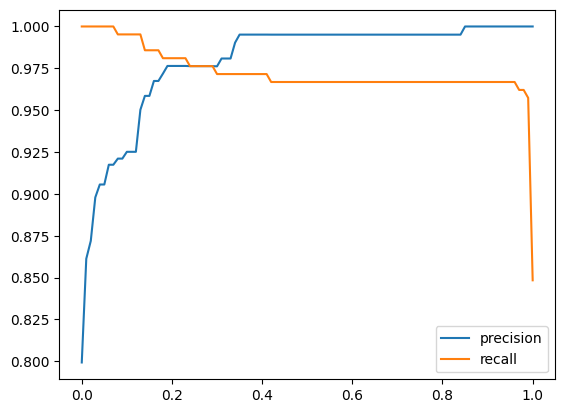

In [19]:
plt.plot(df_scores.thresholds, df_scores.pre, label='precision')
plt.plot(df_scores.thresholds, df_scores.rec, label='recall')

plt.legend()
plt.show()

## Question 4

In [20]:
df_scores['f1'] = 2 * df_scores['pre'] * df_scores['rec']/(df_scores['pre'] + df_scores['rec'])

In [21]:
df_scores.head(30)

,thresholds,tp,fp,fn,tn,tpr,fpr,pre,rec,f1
0,0.00,211,53,0,0,1.000000,1.000000,0.799242,1.000000,0.888421
1,0.01,211,34,0,19,1.000000,0.641509,0.861224,1.000000,0.925439
2,0.02,211,31,0,22,1.000000,0.584906,0.871901,1.000000,0.931567
3,0.03,211,24,0,29,1.000000,0.452830,0.897872,1.000000,0.946188
4,0.04,211,22,0,31,1.000000,0.415094,0.905579,1.000000,0.950450
5,0.05,211,22,0,31,1.000000,0.415094,0.905579,1.000000,0.950450
6,0.06,211,19,0,34,1.000000,0.358491,0.917391,1.000000,0.956916
7,0.07,211,19,0,34,1.000000,0.358491,0.917391,1.000000,0.956916
8,0.08,210,18,1,35,0.995261,0.339623,0.921053,0.995261,0.956720
9,0.09,210,18,1,35,0.995261,0.339623,0.921053,0.995261,0.956720


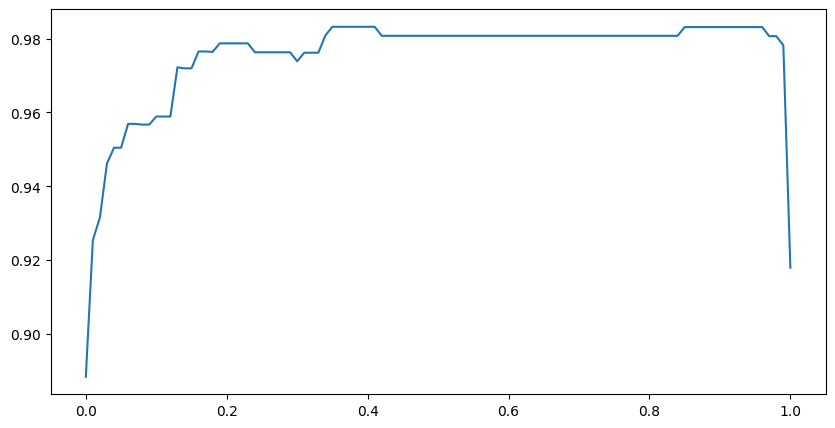

In [22]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.thresholds, df_scores.f1)

In [23]:
df_scores.iloc[df_scores.f1.idxmax()]

thresholds      0.350000
tp            205.000000
fp              1.000000
fn              6.000000
tn             52.000000
tpr             0.971564
fpr             0.018868
pre             0.995146
rec             0.971564
f1              0.983213
Name: 35, dtype: float64

## Question 5

In [24]:
from sklearn.model_selection import KFold

In [33]:
df_full_train , df_test = train_test_split(df_final , test_size = 0.2 , random_state= 1)
df_train , df_val = train_test_split(df_full_train , test_size = 0.25 , random_state= 1)

In [39]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [42]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


## Question 6

In [43]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.996 +- 0.003
C= 0.1, 0.996 +- 0.003
C=   1, 0.996 +- 0.003
C=  10, 0.996 +- 0.003
